#### Objective

The objective of the script is to build a facial expression recognition system. The system includes face preprocessing, feature extraction and classification.

Specifically, the region of interest (i.e., facial image) is extracted using face tracking, face registration and face crop functions.  Basic spatiotemporal features (i.e., LBP-TOP features) are extracted using LBP-TOP. For classificaiton of the extracted features Support Vector Machine (SVM) classifiers are trained. 50 videos from 5 participants are used to train the emotion recognition, using spatiotemporal features. The rest of the data (50 videos) are used to evaluate the performances of the trained recognition system.

#### Database
The original facial expression data is a sub-set of eNTERFACE (acted facial expression), from ten actors acting **happy** and **sadness** behaviors. The used dataset in the exercise includes 100 facial expression samples. 

<!---#### Help-->
<!--- The data and toolbox files used in this exercise can be found in the Affective Computing course webpage (see the Noppa system).
-->

<!---In the exercise, you should know that some basic python libries (numpy, scikit-image, scipy, pyploy, sklearn) before the programming. If you have questions, send your question to us: 
* [Henglin.Shi@oulu.fi](mailto:Henglin.Shi@oulu.fi)
* [Yante.Li@oulu.fi](mail.Yante.Li@oulu.fi)-->

<!---Use the following website to help the usage of python libries. 
* numpy: http://www.numpy.org/
* skimage: https://scikit-image.org/
* scipy: https://www.scipy.org/
* matplotlib.pyplot: https://matplotlib.org/api/pyplot_api.html
* sklearn: http://scikit-learn.org/stable/
    * sklearn.svm: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    * skealrn.metrics.confusion_matrix: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html-->

### Extract facial landmarks

In [2]:
# Loading required libraries
import dlib
import numpy as np
import matplotlib.pyplot as plt
from face_lib import shape2points

TypeError: unsupported operand type(s) for |: '_GenericAlias' and 'NoneType'

In [ ]:
# Load example_img.jpg
img = plt.imread('example_img.jpg')

# Visualize the image
plt.imshow(img)
plt.figure(figsize=(8, 8))

plt.show()

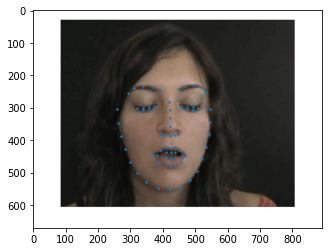

<Figure size 576x576 with 0 Axes>

In [32]:
# Initializing face detector and shape predictor
detector = dlib.get_frontal_face_detector()
#the shape predictor is a neural network that is loaded from the .dat file
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Detect face, return rectangles, each rectangle corresponds to one face.
dets = detector(img, 1)

# Extract the shape of the face in the first rectangle (using the first element of the rectangles variable)
shape_1 = predictor(img, dets[0])

# Extract facial landmarks from shape by calling the shape2points() function.
landmarks = shape2points(shape_1)

# Visualize the landmarks (keypoints) by first plotting the image and then using plt.scatter() for the landmarks
plt.imshow(img)
plt.scatter(landmarks[:, 0], landmarks[:, 1], s=2)
plt.figure(figsize=(8, 8))


plt.show()

### Face normalization

In [33]:
# Load the landmark position of the standard face model from a csv file and store them in standard_model
def load_landmarks_from_csv(
    file_name: str
) -> np.ndarray:
    """
    Reads landmarks from a csv file.
    Arguments
    file_name : A csv file with landmarks
    Returns
    numpy array with the landmarks
    """
    standard_model = np.zeros((68, 2))
    with open(file_name, "r") as f:
        for i, line in enumerate(f.readlines()):
            line_split = line.replace("\n", "").split(",")
            standard_model[i] = [float(value) for value in line_split]
    # Multiply with 500 (width) as the landmarks are normalized
    standard_model *= 500
    return standard_model

standard_model = load_landmarks_from_csv("mean.csv")

<!---**Then you need to calculate the transformation using [`skimage.transform.PolynomialTransform()`](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.PolynomialTransform)**. This class has several methods, expecially, you need to use the **estimate()** method to calculate the transformation between two sets of points. **Registering the example face** by transforming the example image into the standard model space, using [`skimage.transform.warp()`](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.warp) and you calculated transformation. **Cropping the original example image according to the detected landmarks, and the registered image according to the standard face mode. **-->

In [44]:
from skimage import transform
from face_lib import crop_face

# Calculating the transorfmation between the two set of points 
# Instantiating a PolynomialTransform() transform function
t = transform.PolynomialTransform()

# Calculating the transformation by calling the estimate() method.
t.estimate(standard_model, landmarks)


# Warp the example image using the transform.warp() function
warped_img = transform.warp(img, t)
warped_landmarks = transform.warp(landmarks, t)

# Crop the face from registered image using the crop_face function.
#Crop the warped face
cropped_warp = crop_face(warped_img, standard_model)

# Croping the face from the example image using detected landmarks.
cropped_img = crop_face(img, landmarks)


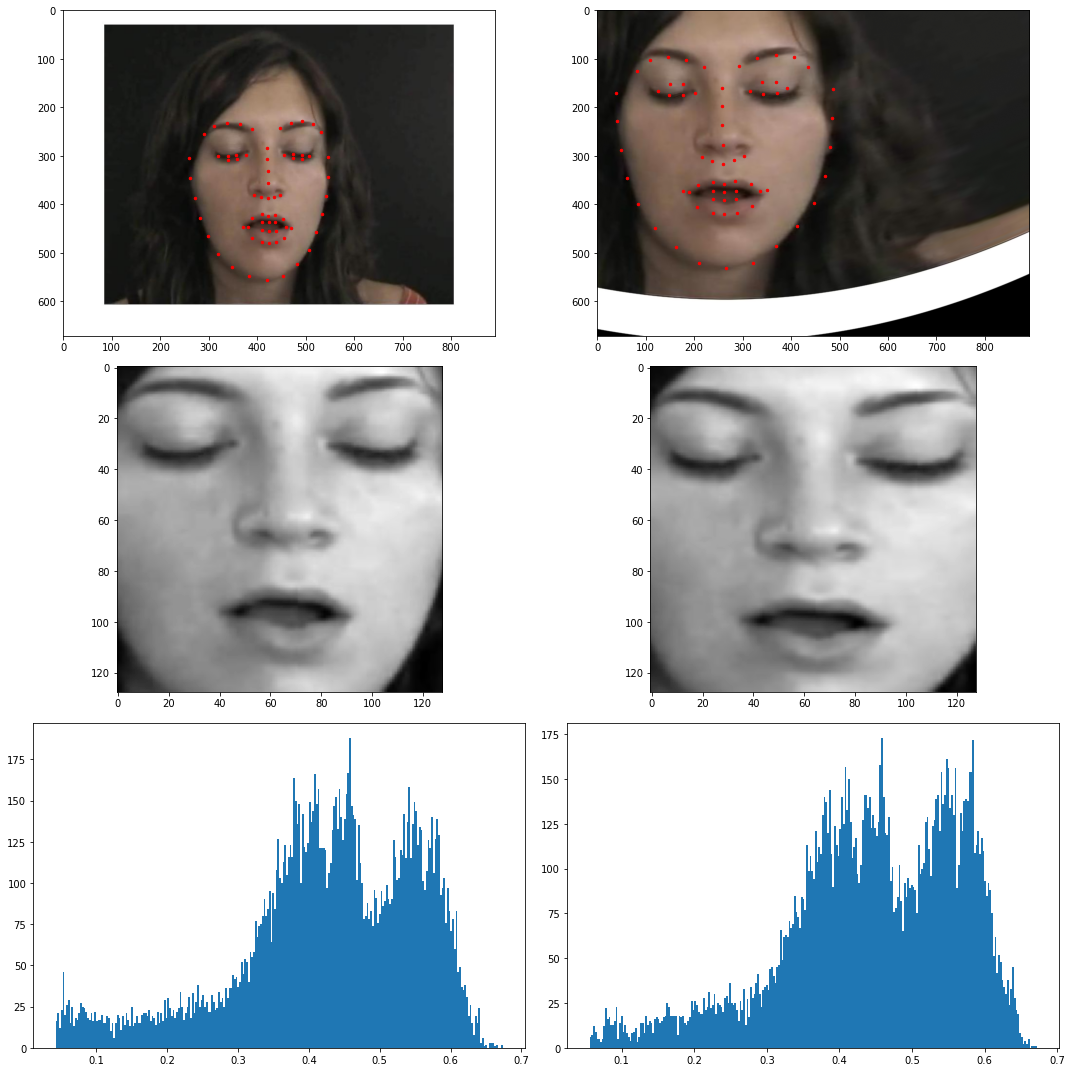

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import img_as_ubyte

# Constructing figure with 2x3 subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

# subplot [0,0]: show the original example image
ax[0, 0].imshow(img)


# Placing detected landmarks on subplot [0,0]
ax[0, 0].scatter(landmarks[:, 0], landmarks[:, 1], c="red", s=6)

    
# subplot [1,0]: show the face cropped from the example image.
ax[1, 0].imshow(cropped_img, "gray")


# subplot [2,0]: show the histogram of the face cropped from the example image.
ax[2, 0].hist(cropped_img.ravel(), bins=256)

# subplot [0,1]: show the registered image
ax[0, 1].imshow(warped_img)

# place the model landmarks on the registered image
ax[0, 1].scatter(standard_model[:, 0], standard_model[:, 1], c="red", s=6)

# subplot [1,1]: show the face cropped from the registered image
ax[1, 1].imshow(cropped_warp, "gray")

# subplot [2,1]: show the histogram of the face cropped from the registered image.
ax[2, 1].hist(cropped_warp.ravel(), bins=256)

fig.tight_layout()
plt.show()

## Feature extraction

C:\Users\KOTI\AppData\Roaming\Python\Python39\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


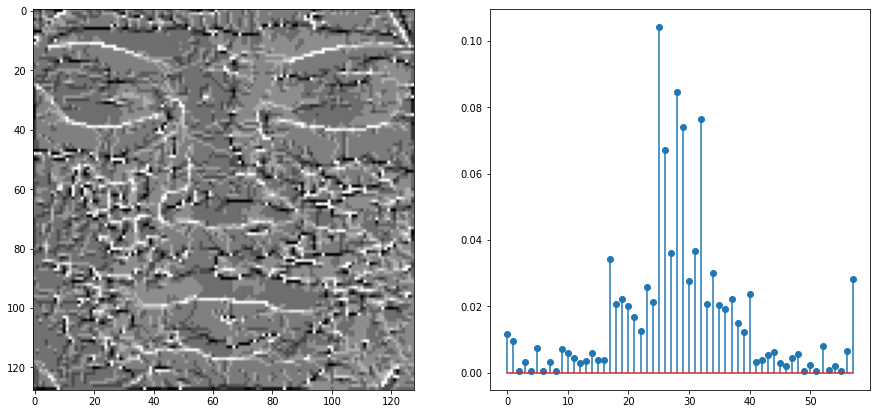

In [71]:
from skimage.feature import local_binary_pattern

# Define the parameters to extract LBP features in (8, 1) neighborhood
# Extract the LBP face using local_binary_pattern() with the defined parameters
lbp_face = local_binary_pattern(cropped_warp, 8, 1.0, method="nri_uniform")

# Calculate the histogram of the LBP face (58 bins). Normalize the histogram's sum to one
histograph = np.histogram(lbp_face, bins=58, density=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(lbp_face,  cmap="gray")
ax[1].stem(histograph[0])

plt.show()



## Feature Classification

In [74]:
import scipy.io as sio

# Loading data using scipy.io.loadmat(), or sio.loadmat
mdata = sio.loadmat("Task3_data.mat")

# Load 'training_data'
sample_train = mdata["training_data"]

# Load 'testing_data'
sample_test = mdata["testing_data"]

# Load 'training_class'
sample_train_class = mdata["training_class"]

# Load 'testing_class'
sample_test_class = mdata["testing_class"]

#Print the shapes from each of the data splits
print(sample_train.shape)
print(sample_test.shape)
print(sample_train_class.shape)
print(sample_test_class.shape)




(50, 708)
(50, 708)
(50, 1)
(50, 1)


### Train SVM classifiers

In [79]:
from sklearn import svm
# 1. Initializing an SVM classifier, using linear kernel
clf = svm.SVC(kernel='linear')

# 2. Use the classifier to fit your training data
clf.fit(sample_train, sample_train_class.ravel())

SVC(kernel='linear')

### Evaluate the classifiers

Training data accuracy: 0.88
Testing data accuracy: 0.72
Training data confusion matrix: [[20  5]
 [ 1 24]]


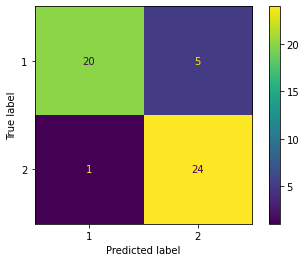

Testing data confusion matrix: [[25  0]
 [14 11]]


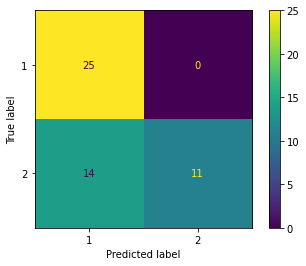

In [89]:
# Predict the training data and testing data.
y_test_pred = clf.predict(sample_test)
y_train_pred = clf.predict(sample_train)


# Calculate the accuracies of the training data and testing data, respectively.
from sklearn.metrics import accuracy_score
print(f"Training data accuracy: {accuracy_score(sample_train_class.ravel(), y_train_pred)}")
print(f"Testing data accuracy: {accuracy_score(sample_test_class.ravel(), y_test_pred)}")


from sklearn.metrics import confusion_matrix

# Print/Draw the confusion matrix using sklearn.metrics.confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#   Calculate the confusion matrix when classifying the training data
print(f"Training data confusion matrix: {confusion_matrix(sample_train_class.ravel(), y_train_pred)}")
# A better view of the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(sample_train_class.ravel(), y_train_pred), display_labels=clf.classes_)
disp.plot()
plt.show()


#   Calculate the confusion matrix when classifying the testing data
print(f"Testing data confusion matrix: {confusion_matrix(sample_test_class.ravel(), y_test_pred)}")
# A better view of the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(sample_test_class.ravel(), y_test_pred), display_labels=clf.classes_)
disp.plot()
plt.show()